In [4]:
%load_ext autoreload
%autoreload 2

# Load packages

In [5]:
import os
import cv2
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt

In [6]:
from ImgAligner.feature import normalize_uint16_to_uint8, orb_feature_matching, \
     compute_homography_and_warp

In [13]:
from ImgAligner.feature import normalize_uint16_to_uint8, orb_feature_matching, \
     akaze_feature_matching, \
     compute_homography_and_warp, scale_search, extract_and_warp_roi_correct, \
     check_local_consistency, piecewise_affine_warp, tps_warp

In [7]:
from ImgAligner.feature.feature_detector import scale_search

In [32]:
from ImgAligner.utils import plot_inlier_matches, adjust_homography_scale

# Process images

In [9]:
# put paths here:
img_path = '/lustre/groups/ml01/workspace/mostafa.shahhosseini/data/MMann/roi_whole_slide/'

In [10]:
# Load ch1, ch2, ch3 for Round 0
img1_ch1 = tf.imread(os.path.join(img_path, 'Round0_ch0.tif'))
img1_ch2 = tf.imread(os.path.join(img_path, 'Round0_ch1.tif'))
img1_ch3 = tf.imread(os.path.join(img_path, 'Round0_ch2.tif'))

# Load ch1, ch2, ch3 for Round 1
img2_ch1 = tf.imread(os.path.join(img_path, 'Round1_ch0.tif'))
img2_ch2 = tf.imread(os.path.join(img_path, 'Round1_ch1.tif'))
img2_ch3 = tf.imread(os.path.join(img_path, 'Round1_ch2.tif'))

In [11]:
sum1 = (img1_ch1.astype(np.uint32) + img1_ch2.astype(np.uint32) + img1_ch3.astype(np.uint32))
img1_rgb = cv2.merge([
    normalize_uint16_to_uint8(sum1),
    normalize_uint16_to_uint8(sum1),
    normalize_uint16_to_uint8(sum1)
])
sum2 = (img2_ch1.astype(np.uint32) + img2_ch2.astype(np.uint32) + img2_ch3.astype(np.uint32))
img2_rgb = cv2.merge([
    normalize_uint16_to_uint8(sum2),
    normalize_uint16_to_uint8(sum2),
    normalize_uint16_to_uint8(sum2)
])


img1_roi = img1_rgb[:, :]
img2_roi = img2_rgb[:, :]

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

##### A technique that improves the contrast of an image by spreading out the intensity values (so darks become darker, brights become brighter).

In [12]:
# --- CLAHE on each channel ---
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
img1_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img1_roi)])
img2_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img2_roi)])

In [9]:
# --- Downsample ---
scale = 0.01
img1_down = cv2.resize(img1_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
img2_down = cv2.resize(img2_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

In [10]:
# Fint match_orb features
orb_features = orb_feature_matching(img1_down, img2_down)
good_matches, kp1, kp2, src_pts, dst_pts = orb_features


In [16]:
len(good_matches)

117

In [33]:
orb_scales = scale_search(img1_enh, img2_enh,scale_range=(0.01, 0.03), n=3, method='orb')

Scale: 0.01
Number of matches: 117


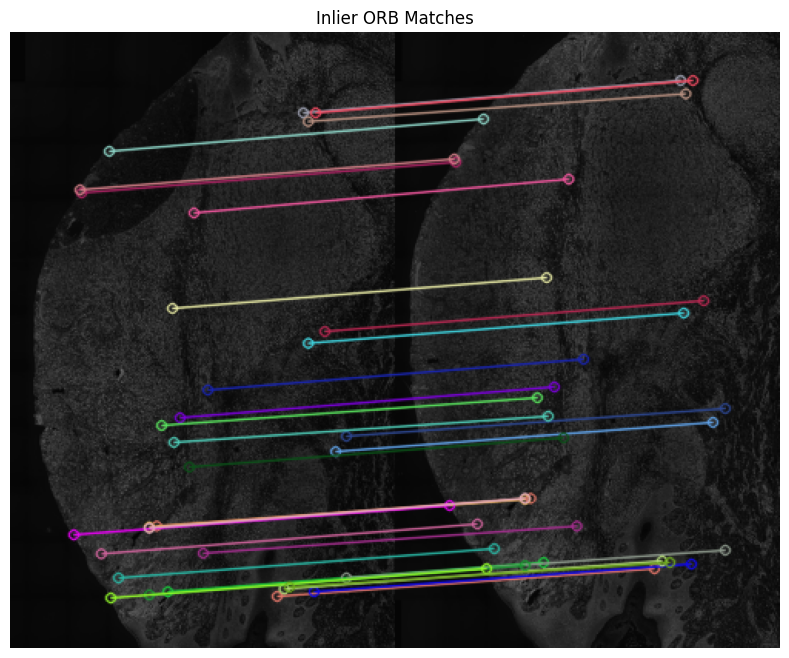

Scale: 0.019999999999999997
Number of matches: 1258


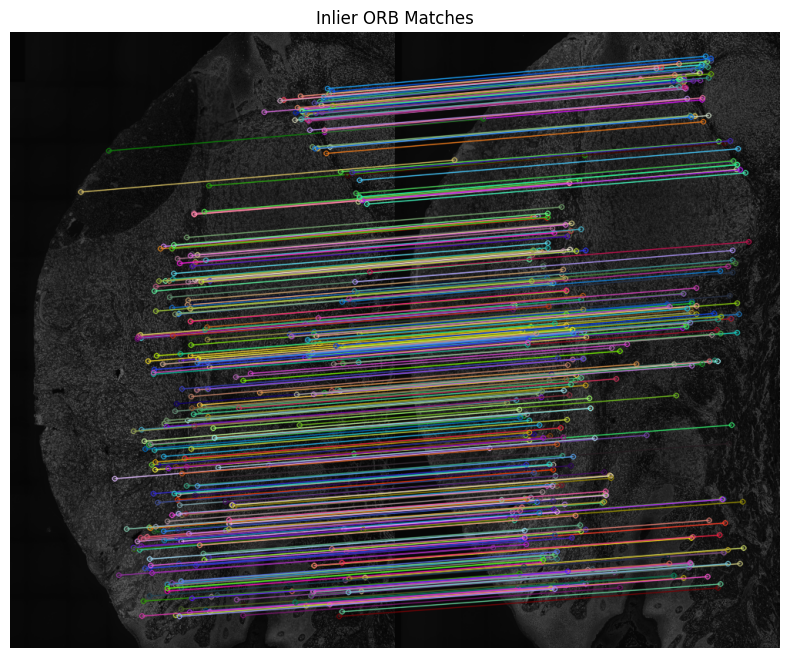

Scale: 0.03
Number of matches: 2200


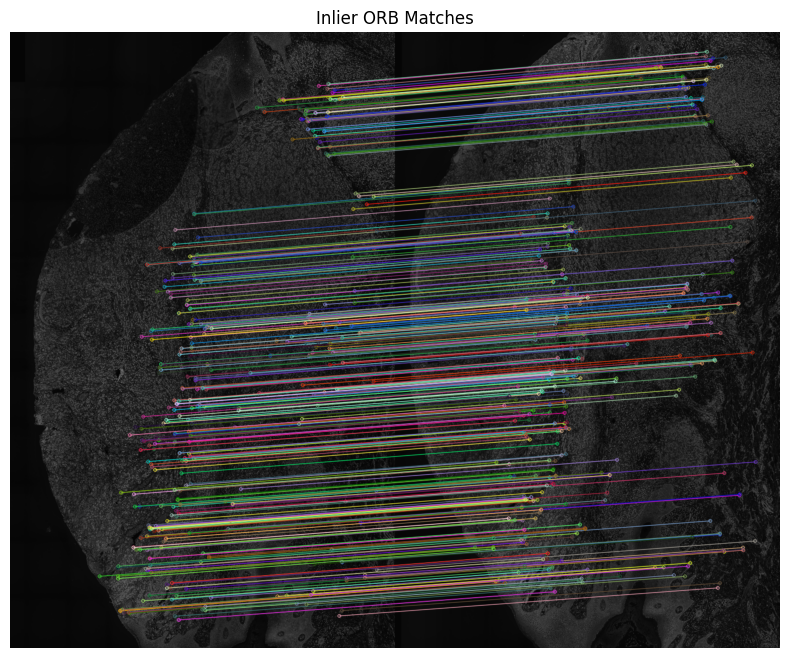

In [34]:
for scale, (img1_scaled, img2_scaled, matches) in orb_scales.items():
    print(f"Scale: {scale}")
    good_matches, kp1, kp2, src_pts, dst_pts = matches
    print(f"Number of matches: {len(good_matches)}")
    H, img2_aligned, inlier_matches = compute_homography_and_warp(img1_scaled, img2_scaled, src_pts, dst_pts, good_matches, ransac_thresh=3.0)
    plot_inlier_matches(img1_scaled, img2_scaled, kp1, kp2, inlier_matches, title="Inlier ORB Matches")
    plt.show()
